### Hash popularity distribution method to find potential Sybil attacks
#### Data preprocessing
- In the voting dataset let's create new feature "amt_str" by concatenating token and rounded donated sum in usd. 
- We applied this algorithm separately for “destination_wallet” and “amt_str” features. For each of them there are “unique” and “list” methods. 
- Sort input table by the time of voting for the “list” method. There is no need to sort if we use the “unique” method.

#### Algorithm
- Group by the source wallet and calculate aggregation as the list of all values (or sorted list of the unique values).
- Create the new hash feature hash by concatenating the values in that list.
- Calculate the new count feature hash_length as the number of values in that list.
- Group by hash and hash_length, calculate the number of rows (wallets) in the group.
- Find the maximum number of wallets with the same hash grouped by hash_length. This series have returned by the Python function for the future visualizations.
- Based on that series values we define potential Sybil attack events the following way: 
    - Compare the values from that series with their neighbors and if one of them in neigh_coef times less this value then it is Sybil attack case. Experimentally we set neigh_coef = 3.
    - Exception: if the value >= max_value then it is not Sybil attack. Maybe it is normal situation when a lot of wallets votes for the same top list. Experimentally we set max_value = 100.
    - Exception: if hash_length <= min_hash then it is not Sybil attack. 
    - Based on visualization set the lists what hash_length we want to manually add or drop.
- Then the next step is to find wallets having this hash and return them.

In [1]:
# Algorithm function
def find_sybil(
    df, feat_group = 'source_wallet', feat_target = 'destination_wallet', 
    feat_date = 'created_ts', target_type = 'unique', 
    neigh_coef = 3, max_value = 100, min_len = 5, sybil_add = [], sybil_drop = []):
    '''
    Function to find potential sybil attacks.
    
    Parameters
    ----------
    df          : input dataframe 
    feat_group  : group feature (source wallet), 
    feat_target : target feature to perform analysis on (for example, destination_wallet)
    feat_date   : datetime feature to sort if target_method is not "unique"
    target_type : if "unique" then creating unique sorted set of values of feat_target feature by the feat_group else just a list of all values.
    neigh_coef  : neighbors comparing coef 
    max_value   : the maximum number of wallets with the same hash to be considered as Sybil attack
    min_len     : the minimum hash lenths to be considered as Sybil attack
    sybil_add   : list of hashes lengths to add manually
    sybil_drop  : list of hashes lengths to drop manually

    Returns
    -------
    - df_sybil     - dataframe with hashes to define Sybil attacks wallets 
    - df_sybil_ids - dataframe with Sybil attack wallets by these hashes
    - s            - series with the maximum number of wallets with the same hash grouped by hash length
    '''
    # - Sort dataframe by datetime feature if considering the method with all sequence of items (for not unique case)
    if target_type != 'unique':
        df = df.sort_values(feat_date)
        fun_agg = lambda x: list(x)
    else: 
        fun_agg = lambda x: sorted(set(x))

    # - Group by the feat_group feature and calculate the aggregation as the list of all values (maybe unique)
    df1 = df.groupby(feat_group).agg({
        feat_target: fun_agg, 
    }).reset_index()
    
    # - Create count feature as the number of elements in the aggregated feature
    df1['hash_len'] = df1[feat_target].map(len)
    # - Create hash value of that feature by concating the values in the list
    df1['hash'] = df1[feat_target].map(lambda x: ';'.join(x))
    del df1[feat_target]
    
    # - Group by that hash and calculate the number of rows in the group
    df2 = df1.groupby(['hash','hash_len'])[feat_group].count().reset_index()
    df2.sort_values(['hash_len',feat_group], ascending = [True,False], inplace = True)

    # - Find the maximum number of wallets with the same hash grouped by hash length
    s = df2.groupby('hash_len')[feat_group].max()

    # - Compare the number of wallets with the same hash with their neighbors and define the Sybil attack wallets   
    s1 = s.reset_index()
    s1[f'{feat_group}_prev'] = s1[feat_group].shift(1)
    s1[f'{feat_group}_next'] = s1[feat_group].shift(-1)
    
    del s1[feat_group]
    df2 = df2.merge(s1)
    f1 = df2[feat_group]/df2[f'{feat_group}_prev'] >= neigh_coef
    f2 = df2[feat_group]/df2[f'{feat_group}_next'] >= neigh_coef
    f3 = df2[feat_group] >= max_value
    f4 = df2['hash_len'] <= min_len
    
    df2['flg_sybil'] = 0
    df2.loc[f1, 'flg_sybil'] = 1
    df2.loc[f2, 'flg_sybil'] = 1
    df2.loc[f3, 'flg_sybil'] = 0
    df2.loc[f4, 'flg_sybil'] = 0

    # - Create dataframe with hashes to define Sybil attacks wallets 
    sybil_add_vals = [s[i] for i in sybil_add]
    f1 = df2.flg_sybil == 1
    f2 = (df2.hash_len.isin(sybil_add)) & (df2[feat_group].isin(sybil_add_vals))
    f3 = ~df2.hash_len.isin(sybil_drop)
    df_sybil = df2[(f1|f2)&f3][['hash','hash_len',feat_group]].reset_index()
    del df_sybil['index']

    # - Create dataframe with Sybil attack wallets by these hashes
    df_sybil_ids = df_sybil[['hash']].merge(df1)
    # del df_sybil_ids['hash']

    return df_sybil, df_sybil_ids, s

In [2]:
# Read dataset
df = pd.read_csv('data/data_rounds.csv')

# Data preprocessing
def float2str(x):
    x = str(x).split('.')
    x1 = x[0]
    x2 =  x[1][:2] if len(x) > 1 else '00'
    x2 = x2 if len(x2) == 2 else x2 + '0'
    return  f'{x1}.{x2}'
df['amt_str'] = df.token + '=' + df.amt_usd.map(float2str)

print(df.shape)
df[:2]

(753275, 9)


,round_name,source_wallet,destination_wallet,created_ts,created_dt,amt_usd,amt_token,token,amt_str
0,1_gitcoin_gr15,0x76f69dcddd0593b0aff5fd3280c3433ddb68e0d2,id_12,1663891197,2022-09-22 23:59:57,0.06,0.00,ETH,ETH=0.06
1,1_gitcoin_gr15,0x76f69dcddd0593b0aff5fd3280c3433ddb68e0d2,id_6972,1663891195,2022-09-22 23:59:55,1.28,0.00,ETH,ETH=1.28


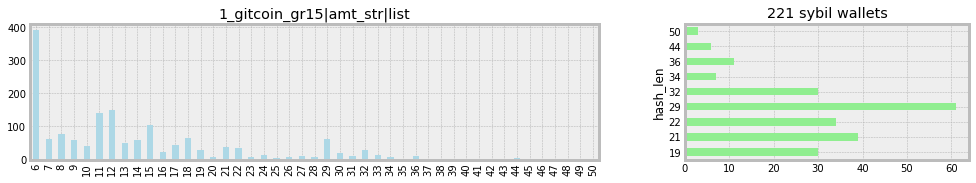

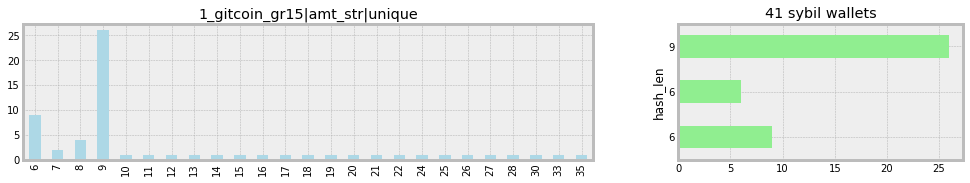

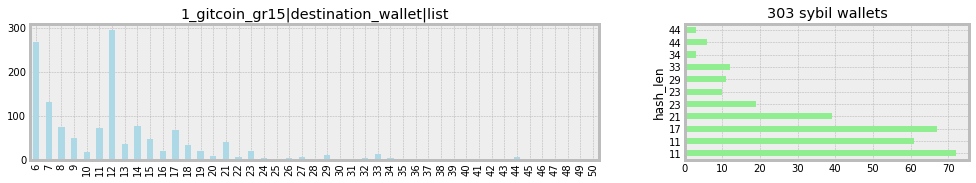

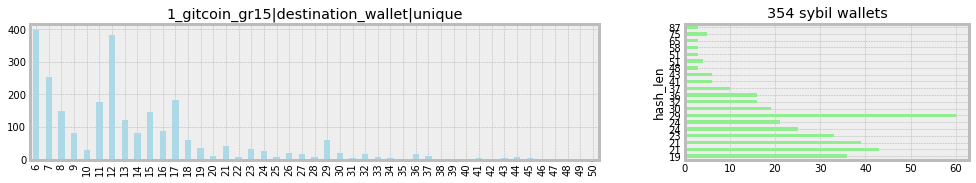

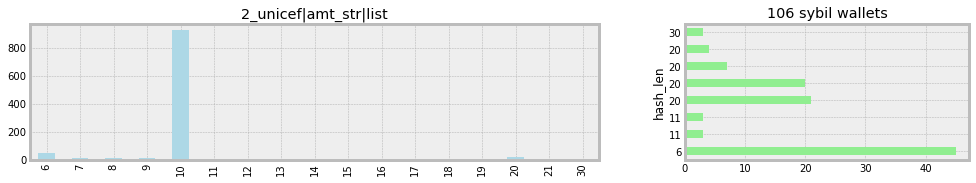

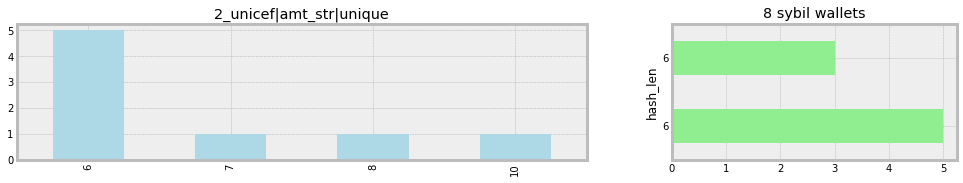

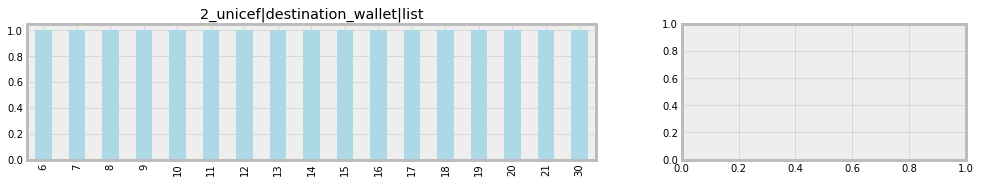

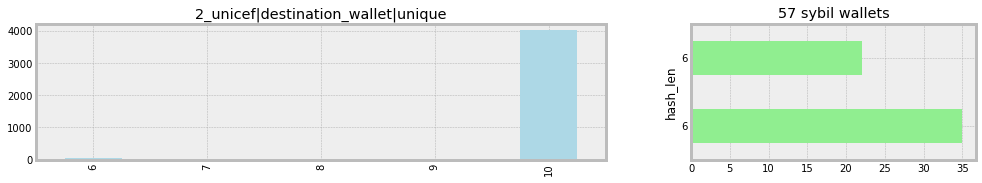

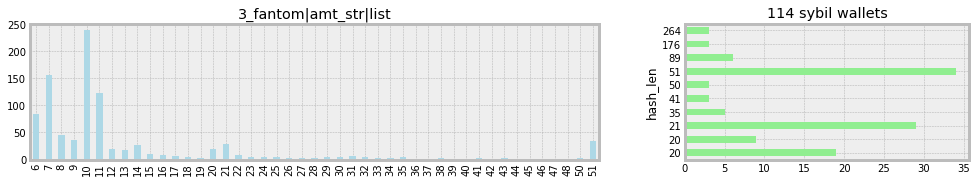

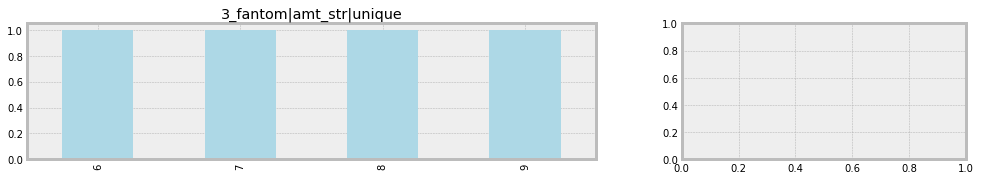

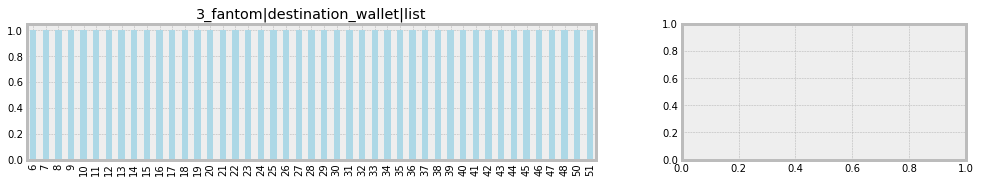

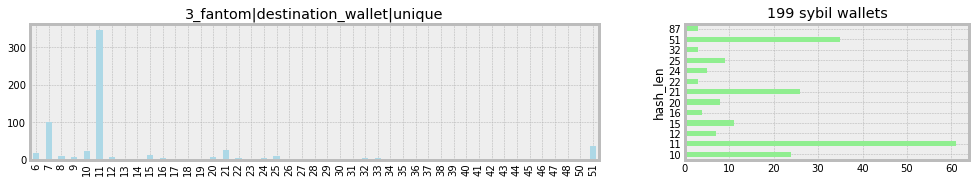

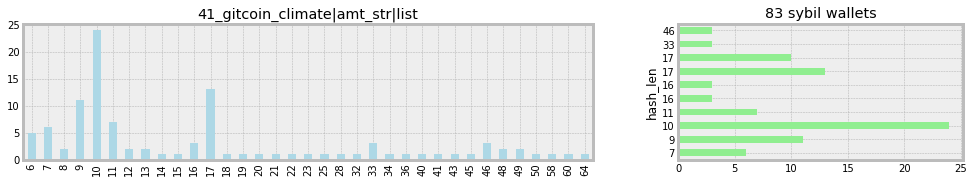

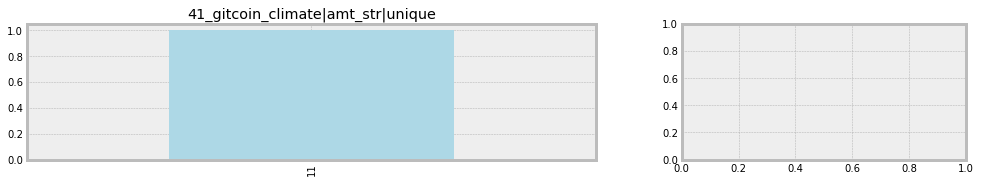

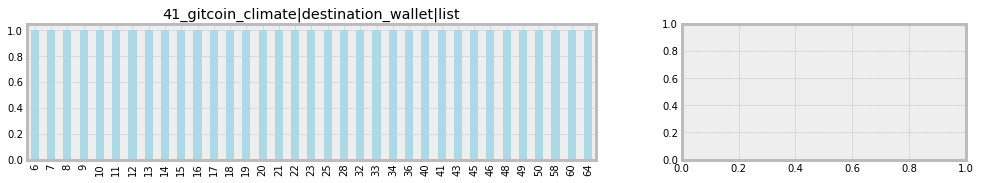

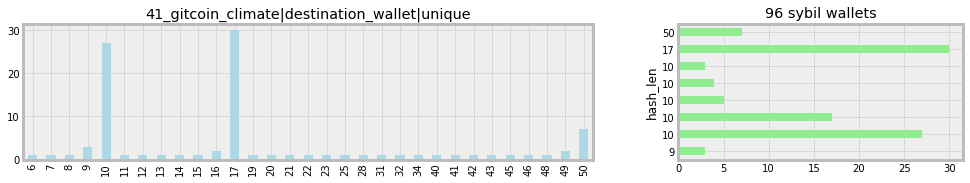

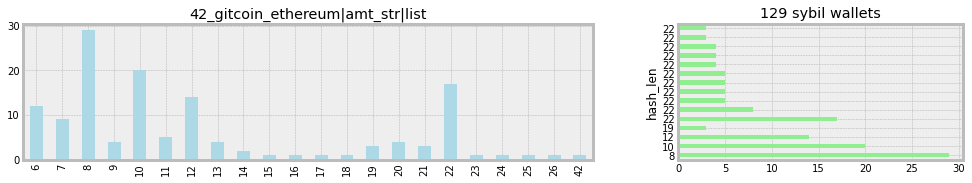

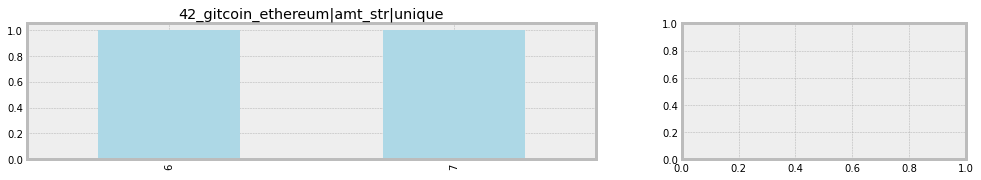

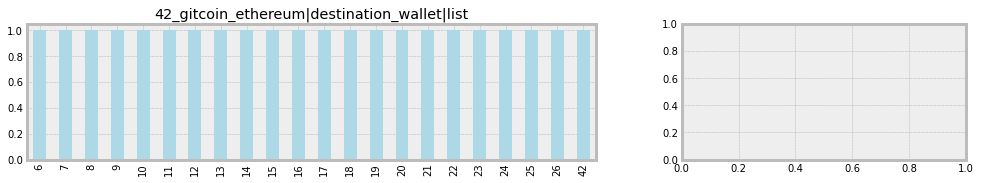

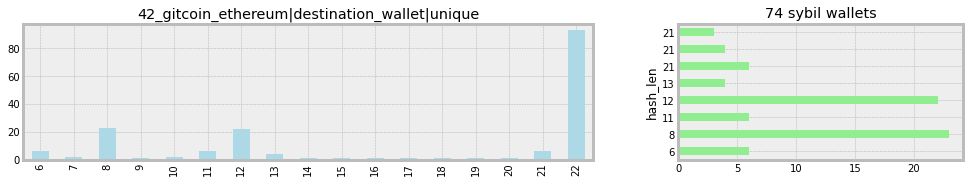

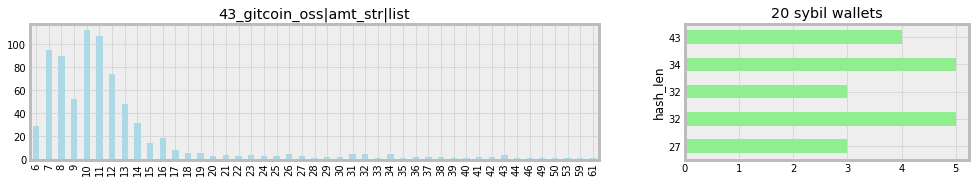

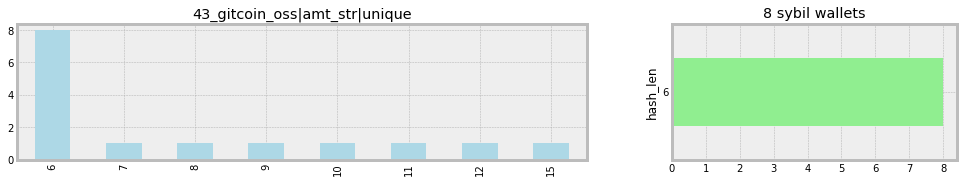

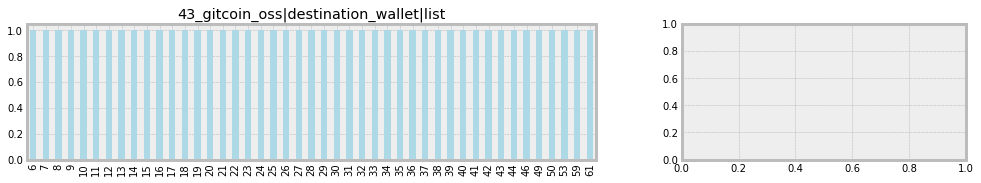

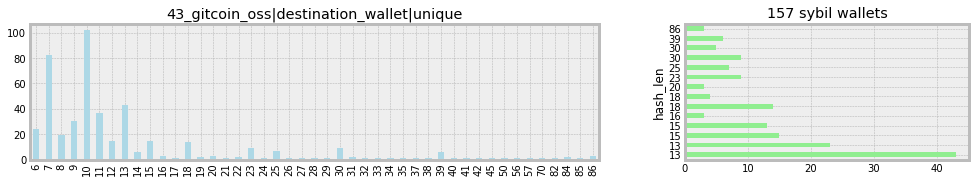

In [3]:
# Finding Sybil attacks
plt.style.use('bmh')
%matplotlib inline
df_sybil_ids_all = pd.DataFrame()

dict_sybil_drop = {
    '2_unicef|amt_str|list': [10],
    '3_fantom|amt_str|list': [88],
    '42_gitcoin_ethereum|amt_str|list':   [7],
    '42_gitcoin_ethereum|destination_wallet|unique': [22],
    '43_gitcoin_oss|amt_str|list':   [7],
    '43_gitcoin_oss|destination_wallet|unique': [7],
}
dict_sybil_add = {
}

for feat_round in '1_gitcoin_gr15 2_unicef 3_fantom 41_gitcoin_climate 42_gitcoin_ethereum 43_gitcoin_oss'.split(' ')[0:]:
    for feat_target in 'amt_str destination_wallet'.split(' '):
        for target_type in 'list unique'.split(' '):
            exec_name = f'{feat_round}|{feat_target}|{target_type}'
            # print(exec_name)
            df_sybil,df_sybil_ids,s1 = find_sybil(
                                    df[df.round_name==feat_round], 
                                    feat_target=feat_target, 
                                    target_type=target_type, 
                                    neigh_coef=3,
                                    sybil_add=dict_sybil_add[exec_name] if exec_name in dict_sybil_add else [],
                                    sybil_drop=dict_sybil_drop[exec_name] if exec_name in dict_sybil_drop else [], 
                                    )

            # results
            _, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize = (15,2.5))
            i1,i2 = [5,50]
            p = s1[i1:i2].plot(kind = 'bar', ax = ax[0], xlabel = '', title = exec_name, color = 'lightblue')
            cnt = df_sybil.source_wallet.sum()
            if cnt > 0:
                df_sybil.set_index('hash_len')['source_wallet'].plot(ax = ax[1], kind = 'barh', title = f'{cnt} sybil wallets', color = 'lightgreen')
            plt.show()

            # merge results
            df_sybil_ids['feat_round'] = feat_round
            df_sybil_ids['feat_target'] = feat_target
            df_sybil_ids['target_type'] = target_type
            df_sybil_ids_all = pd.concat([df_sybil_ids_all, df_sybil_ids])

In [4]:
# The results
df_sybil_ids_all.to_csv('data/data_sybils.csv', index = False)
print(df_sybil_ids_all.shape)
df_sybil_ids_all[:5]

(1970, 6)


,hash,source_wallet,hash_len,feat_round,feat_target,target_type
0,ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;E...,0x0d578a998f3e6d1959acf5cf7e83078212b767ca,19,1_gitcoin_gr15,amt_str,list
1,ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;E...,0x16d7d09d45e76abc63c0999266ec1590f3f08431,19,1_gitcoin_gr15,amt_str,list
2,ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;E...,0x1a7f8272fb94eff33c51aa1e22cd0c6067f801d9,19,1_gitcoin_gr15,amt_str,list
3,ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;E...,0x22b2c3055725b847caecebb081feb3da57df3754,19,1_gitcoin_gr15,amt_str,list
4,ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;ETH=1.00;E...,0x2532000e2e647b9b6d50eeae39726d6ee029d030,19,1_gitcoin_gr15,amt_str,list


In [5]:
# Create all unique pairs of wallets by the same hash
x = df_sybil_ids_all.groupby(['feat_round','hash'])['source_wallet'].agg(lambda x: set(x))
print(x.shape)
list1 = list()
list2 = list()
for ind,x1 in x.iteritems():
    out = list()
    for wals in itertools.combinations(x1,2):
        out.append('_'.join(sorted(wals)))
    list1+=out
    list2+=[ind[0]]*len(out)
df2 = pd.DataFrame({
    'round_name': list2,
    'wallets': list1,
})
df2.drop_duplicates(inplace = True)
df2.to_csv('data/data_sybils_pairs.csv', index = False)
print(df2.shape)
df2[:5]

(139,)
(23983, 2)


,round_name,wallets
0,1_gitcoin_gr15,0x8e6327a2513c4e9ceaf1080d5cb35442b737bf40_0xc...
1,1_gitcoin_gr15,0x0c85891c036ecd0dd902ebb722a4ecb71e8e0d12_0x8...
2,1_gitcoin_gr15,0x0e5610b7e42e134d9d57224db6b47ce75afa87c9_0x8...
3,1_gitcoin_gr15,0x8e6327a2513c4e9ceaf1080d5cb35442b737bf40_0xa...
4,1_gitcoin_gr15,0x5ba1031bb03110d4443f5df83002338428c4c8eb_0x8...
